In [3]:
import os
import sys
import math
import argparse
import numpy as np
from collections import Counter

# Keras imports
from keras.models import Model
from keras import backend as K

# ML4CVD Imports
from ml4cvd.arguments import parse_args
from ml4cvd.models import make_multimodal_multitask_model, train_model_from_generators
from ml4cvd.tensor_generators import TensorGenerator, big_batch_from_minibatch_generator, test_train_valid_tensor_generators

# IPython imports
from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '


In [4]:
def gradients_from_output(args, model, output_layer, output_index):
    K.set_learning_phase(1)
    input_tensor = model.input
    x = model.get_layer(output_layer).output[:,output_index]
    grads = K.gradients(x, input_tensor)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-6) # normalization trick: we normalize the gradient
    iterate = K.function([input_tensor], [x, grads])
    return iterate

def saliency_map(input_tensor, model, output_layer, output_index):
    get_gradients = gradients_from_output(args, model, output_layer, output_index)
    activation, grads = get_gradients([input_tensor])
    print('Activation is:', activation, 'gradient shape:', grads.shape)
    return grads


In [5]:
def plot_ecgs(ecgs, rows=3, cols=4, time_interval=2.5, raw_scale=0.005, hertz=500):
    _, axes = plt.subplots(rows, cols, figsize=(18, 16))
    for i in range(rows):
        for j in range(cols):
            start = int(i*time_interval*hertz)
            stop = int((i+1)*time_interval*hertz)
            axes[i, j].set_xlim(start, stop)
            for label in ecgs:
                axes[i, j].plot(range(start, stop), ecgs[label][start:stop, j + i*cols] * raw_scale, label=label)  
            axes[i, j].legend(loc='lower right')
            axes[i, j].set_xlabel('milliseconds')

In [11]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/sax-lax-40k-teacher/2019-11-21/', 
            '--input_tensors', 'ecg_rest', 
            '--output_tensors', 'qt-interval',
            '--batch_size', '6',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--model_file', '/mnt/ml4cvd/projects/models/ecg_rest_qt_only/ecg_rest_qt_only.hd5',
            '--id', 'ecg_rest_qt_only']
args = parse_args()
model = make_multimodal_multitask_model(**args.__dict__)
generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
test_data, test_labels, test_paths = big_batch_from_minibatch_generator(generate_test, args.test_steps)
test_tensor = test_data['input_strip_ecg_rest']
grads_qt = saliency_map(test_tensor, model, 'output_QTInterval_continuous', 0)

2019-12-20 09:33:32,400 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/ecg_rest_qt_only/log_2019-12-20_09-33_0.log.
2019-12-20 09:33:32,402 - arguments:196 - INFO - Command Line was:

./scripts/tf.sh train --tensors /mnt/disks/sax-lax-40k-teacher/2019-11-21/ --input_tensors ecg_rest --output_tensors qt-interval --batch_size 6 --epochs 2 --learning_rate 0.001 --training_steps 128 --validation_steps 10 --test_steps 1 --model_file /mnt/ml4cvd/projects/models/ecg_rest_qt_only/ecg_rest_qt_only.hd5 --id ecg_rest_qt_only



2019-12-20 09:33:32,404 - arguments:197 - INFO - Total TensorMaps:350 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=6, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, cache_size=1000000000.0, categorical_field_ids=[]

2019-12-20 09:33:41,109 - tensor_generators:426 - INFO - Found 24451 train, 7045 validation, and 7435 testing tensors at: /mnt/disks/sax-lax-40k-teacher/2019-11-21/
2019-12-20 09:33:41,158 - tensor_generators:138 - INFO - Stopping test_worker_0.
2019-12-20 09:33:41,160 - tensor_generators:138 - INFO - Stopping test_worker_1.
2019-12-20 09:33:41,161 - tensor_generators:138 - INFO - Stopping test_worker_2.
2019-12-20 09:33:41,172 - tensor_generators:138 - INFO - Stopping test_worker_3.
2019-12-20 09:33:41,182 - tensor_generators:110 - INFO - Starting test_worker_0.
2019-12-20 09:33:41,190 - tensor_generators:234 - INFO - test_worker_0 initialized cache of size 0.000 GB.
2019-12-20 09:33:41,235 - tensor_generators:110 - INFO - Starting test_worker_1.
2019-12-20 09:33:41,245 - tensor_generators:234 - INFO - test_worker_1 initialized cache of size 0.000 GB.
2019-12-20 09:33:41,280 - tensor_generators:110 - INFO - Starting test_worker_2.
2019-12-20 09:33:41,290 - tensor_generators:234 - INFO

In [12]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/sax-lax-40k-teacher/2019-11-21/', 
            '--input_tensors', 'ecg_rest', 
            '--output_tensors', 'ventricular-rate',
            '--batch_size', '6',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--model_file', '/mnt/ml4cvd/projects/models/ecg_rest_ventricular_rate/ecg_rest_ventricular_rate.hd5',
            '--id', 'ecg_rest_ventricular_rate']
args = parse_args()
model = make_multimodal_multitask_model(**args.__dict__)
grads_vr = saliency_map(test_tensor, model, 'output_VentricularRate_continuous', 0)

2019-12-20 09:33:43,474 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/ecg_rest_ventricular_rate/log_2019-12-20_09-33_0.log.
2019-12-20 09:33:43,475 - arguments:196 - INFO - Command Line was:

./scripts/tf.sh train --tensors /mnt/disks/sax-lax-40k-teacher/2019-11-21/ --input_tensors ecg_rest --output_tensors ventricular-rate --batch_size 6 --epochs 2 --learning_rate 0.001 --training_steps 128 --validation_steps 10 --test_steps 1 --model_file /mnt/ml4cvd/projects/models/ecg_rest_ventricular_rate/ecg_rest_ventricular_rate.hd5 --id ecg_rest_ventricular_rate



2019-12-20 09:33:43,478 - arguments:197 - INFO - Total TensorMaps:350 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=6, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, cache_si

Activation is: [ 0.00661375  1.1704156   0.71118784  0.08868174 -0.75004685 -0.3494183 ] gradient shape: (6, 5000, 12)


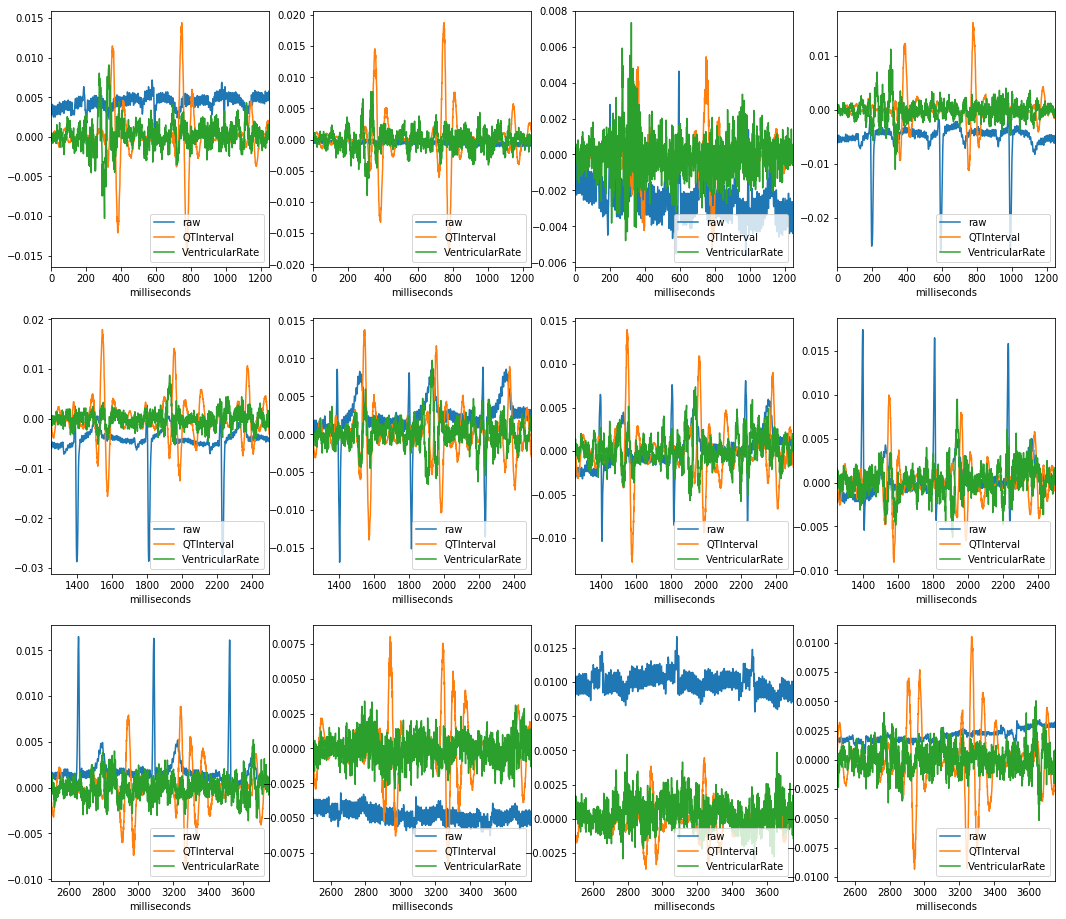

In [13]:
ecg_dict = {'raw': test_tensor[1], 'QTInterval': grads_qt[1], 'VentricularRate': grads_vr[1]} 
plot_ecgs(ecg_dict)